### Setup

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [2]:

# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py ./going_modular/going_modular
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
     

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3815, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 3815 (delta 242), reused 400 (delta 196), pack-reused 3357
Receiving objects: 100% (3815/3815), 650.61 MiB | 25.35 MiB/s, done.
Resolving deltas: 100% (2198/2198), done.
Updating files: 100% (248/248), done.


In [3]:
import os

old_name = r"./going_modular"
new_name = r"./scripts"
os.rename(old_name, new_name)   

In [4]:
old_name = r"./scripts/going_modular"
new_name = r"./scripts/scripts"
os.rename(old_name, new_name)

In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# Check the GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [7]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

### Get Data

In [8]:
# Make a helper function to download data


import os
import zipfile

from pathlib import Path

import requests

def download_data(source:str,
                  destination:str,
                  remove_source: bool = True) -> Path:
  """
  Downloads a zipped dataset from source and unzips to destination
  """

  # Setup path to data folder
  data_path = Path("data/")
  image_path = data_path/destination

  # If data path doesnot exist, create one
  if data_path.is_dir():
    print(f"[INFO] {data_path} already exists, Not going to create again")
  else:
    print(f"[INFO] {data_path} doesnot exist. Creating ...")
    os.mkdir("data")

  # If image path doesn't exist, download it and prepare it
  if image_path.is_dir():
    print(f"[INFO] {image_path} directory exists, skipping re-download")
  else:
    print(f"[INFO] Didnot found {image_path}, downloading it .....")
    
    # Download the target data
    target_file = Path(source).name
    with open(data_path/target_file, "wb") as f:
      request = requests.get(source)
      print("Downloading .......")
      f.write(request.content)

    # Unzip
    with zipfile.ZipFile(data_path/target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data ...")
      zip_ref.extractall(image_path)

    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path/target_file)

  return image_path

In [9]:
source_path = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
image_path = download_data(source = source_path,
                           destination = "pizza_steak_sushi")

[INFO] data doesnot exist. Creating ...
[INFO] Didnot found data/pizza_steak_sushi, downloading it .....
[INFO] Unzipping pizza_steak_sushi.zip data ...


In [10]:
image_path

PosixPath('data/pizza_steak_sushi')

In [11]:
# Setup directory path

train_dir = image_path/ "train"
test_dir = image_path/ "test"

In [12]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Image folders to Datasets and DataLoaders

Let's create our dataloader.

#### Creating transforms

We can create transforms using `transforms.Compose`

In [13]:
from torchvision import transforms

IMG_SIZE = 224


# Create manual transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
                                        ])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [14]:
# The paper actually uses a batch size of 4096 but it is too big for the resources
BATCH_SIZE = 32

#### Creating DataLoaders using automatic transforms

In [15]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir, test_dir = test_dir, transform = manual_transforms, batch_size = BATCH_SIZE)

In [16]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7efcf4e4b4f0>,
 ['pizza', 'steak', 'sushi'])

In [17]:
len(train_dataloader)

8

In [18]:
len(test_dataloader)

3

#### Visualize a single Image

In [19]:
for i in train_dataloader:
  image_label = i
  pass

In [20]:
image = image_label[0].squeeze(0)
label = image_label[1]

Text(0.5, 1.0, 'steak')

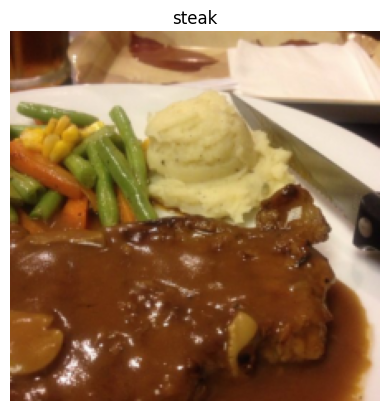

In [21]:
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)
plt.title(class_names[label])

## 3. Replicating the ViT paper: an overview

Before we write anymore code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our **model inputs** are: images of pizza, steak and sushi.

And our ideal **model outputs** are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

### 3.1 Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of **layers**.

And a collection of layers is often referred to as a **block**.

And stacking many blocks together is what gives us the whole architecture.

A **layer** takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an output.

So if a **single layer** takes an input and gives an output, then a collection of layers or a **block** also takes an input and gives an output.

Let's make this concrete:
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>

*A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (for example, the self-attention formula pictured above, however, this function could be almost anything) and then output it. Blocks are generally stacks of layers on top of each other doing a similar thing to a single layer but multiple times.* 

### 3.2 Getting specific: What's ViT made of?

There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:
1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.* 

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1). 
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast. 

> **Note:** We're going to focused on write PyTorch code to create these layers, for the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** | 
| ----- | ----- | 
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like: 

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.5 Equation 3 overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like: 

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture. 

### 3.3 My workflow for replicating papers

When I start working on replicating a paper, I go through the following steps:

1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use [mathpix.com](https://mathpix.com/) (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-mathpix-demo.gif" width=900 alt="using mathpix.com to turn text from a machine learning research paper (PDF) into editable LaTeX"/>

*Turning the four equations from the ViT paper into editable LaTeX/markdown using [mathpix.com](https://mathpix.com/).* 

We've already gone through the first few steps above (and if you haven't read the full paper yet, I'd encourage you to give it a go) but what we'll be focusing on next is step 5: replicating the simplest version fo the model possible.

This is why we're starting with ViT-Base.

Replicating the smallest version of the architecture possible, get it working and then we can scale up if we wanted to.

> **Note:** If you've never read a research paper before, many of the above steps can be intimidating. But don't worry, like anything, your skills at reading *and* replicating papers will improve with practice. Don't forget, a research paper is often *months* of work by many people compressed into a few pages. So trying to replicate it on your own is no small feat. 

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding 

I remember one of my machine learning engineer friends used to say "it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as **embeddings are learnable representations**), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector. 

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper: 

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

### 4.1 Calculating patch embedding input and output shapes by hand

How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [22]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
